## 1) Linear Regression on Energy Effciency

In [28]:
#Printing the Head Values
import pandas as pd
energy = pd.read_excel('ENB2012_data.xlsx')
energy.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [29]:
#Renaming the coulmns 
energy.columns = ['relative_compactness', 'surface_area', 'wall_area', 'roof_area', 'overall_height',
                'orientation', 'glazing_area', 'glazing_area_distribution', 'heating_load', 'cooling_load']

In [30]:
energy.head()

,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


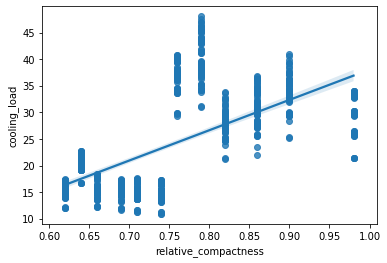

In [31]:
import seaborn as sns
#regression plot
sns.regplot(x="relative_compactness", y="cooling_load",data=energy)

In [32]:
#Firstly, we normalise our dataset to a common scale using the min max scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression,Ridge,Lasso
scaler = MinMaxScaler()
normalised_df = pd.DataFrame(scaler.fit_transform(energy), columns=energy.columns)
features_df = normalised_df.drop(columns=['heating_load', 'cooling_load'])
heating_target = normalised_df['heating_load']


#Now, we split our dataset into the training and testing dataset. Recall that we had earlier segmented the features and target variables.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features_df, heating_target, test_size=0.3, random_state=1)

linear_model = LinearRegression()
#fit the model to the training dataset
linear_model.fit(x_train, y_train)
#obtain predictions
predicted_values = linear_model.predict(x_test)


#MAE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predicted_values)
round(mae, 3) 	#prints 0.063

0.063

In [33]:
from sklearn.metrics import r2_score
r2_score = r2_score(y_test, predicted_values)
round(r2_score, 3)	#prints 0.893

0.894

In [34]:
import numpy as np
rss = np.sum(np.square(y_test - predicted_values))
round(rss, 3)  #prints 1.823

1.817

In [35]:
from sklearn.metrics import  mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, predicted_values))
round(rmse, 3) 	#prints 0.089

0.089

In [39]:
#comparing the effects of regularisation
def get_weights_df(model, feat, col_name):
  #this function returns the weight of every feature
    model.fit(x_train,y_train)
    weights = pd.Series(model.coef_, feat.columns).sort_values()
    weights_df = pd.DataFrame(weights).reset_index()
    weights_df.columns = ['Features', col_name]
    weights_df[col_name].round(3)
    return weights_df

In [40]:
model = LinearRegression()
lasso_reg = Lasso(alpha=0.001)

linear_model_weights = get_weights_df(model, x_train, 'Linear_Model_Weight')
ridge_weights_df = get_weights_df(ridge_reg, x_train, 'Ridge_Weight')
lasso_weights_df = get_weights_df(lasso_reg, x_train, 'Lasso_weight')


final_weights = pd.merge(linear_model_weights, ridge_weights_df, on='Features')
final_weights = pd.merge(final_weights, lasso_weights_df, on='Features')

In [41]:
final_weights

,Features,Linear_Model_Weight,Ridge_Weight,Lasso_weight
0,relative_compactness,-0.606412,-0.207837,-0.027719
1,roof_area,-0.328099,-0.138496,-0.000000
2,surface_area,-0.235022,-0.030334,0.000000
3,orientation,0.003399,0.003388,0.000000
4,wall_area,0.018947,0.126065,0.200087
5,glazing_area_distribution,0.028452,0.029801,0.021431
6,glazing_area,0.215042,0.210513,0.206132
7,overall_height,0.393549,0.436543,0.463482


In [45]:
from sklearn.model_selection import cross_val_score
# function to get cross validation scores
def get_cv_scores(model):
    scores = cross_val_score(model,
                             x_train,
                             y_train,
                             cv=5,
                             scoring='r2')
    
    print('CV Mean: ', np.mean(scores))
    print('STD: ', np.std(scores))
    print('\n')

In [46]:
# Train model
lr = LinearRegression().fit(x_train, y_train)

In [47]:
# get cross val scores
get_cv_scores(lr)

CV Mean:  0.92228466009796
STD:  0.007244988845630018




In [53]:
# Train model with default alpha=1
ridge = Ridge(alpha=0.001).fit(x_train, y_train)
# get cross val scores
get_cv_scores(ridge)

CV Mean:  0.9222846932429978
STD:  0.007241750316064149




In [52]:
from sklearn.model_selection import GridSearchCV
# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(x_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Score:  0.9222846932429979
Best Params:  {'alpha': 0.001}


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    4.6s finished


In [59]:
from sklearn.linear_model import Lasso
# Train model with default alpha=1
lasso = Lasso(alpha=0.001).fit(x_train, y_train)
# get cross val scores
get_cv_scores(lasso)

CV Mean:  0.9181876564791125
STD:  0.007246882077998089




In [58]:
# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(x_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score:  0.9181876564791125
Best Params:  {'alpha': 0.001}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.0s finished


In [62]:
from sklearn.linear_model import ElasticNet
# Train model with default alpha=1 and l1_ratio=0.5
elastic_net = ElasticNet(alpha=0.001, l1_ratio=0.5).fit(x_train, y_train)
# get cross val scores
get_cv_scores(elastic_net)

CV Mean:  0.9191156453156593
STD:  0.006702032195119788




In [61]:
# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
l1_ratio = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
param_grid = dict(alpha=alpha, l1_ratio=l1_ratio)
grid = GridSearchCV(estimator=elastic_net, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(x_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 77 candidates, totalling 385 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


Best Score:  0.9210448631888278
Best Params:  {'alpha': 0.001, 'l1_ratio': 0}


[Parallel(n_jobs=-1)]: Done 385 out of 385 | elapsed:    0.6s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5963932180607634, tolerance: 0.003944969110754325
  positive)
